In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import re
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

2025-01-27 15:38:57.180172: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-27 15:38:57.180789: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-27 15:38:57.182864: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-27 15:38:57.189215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737988737.200529   32334 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737988737.20

In [2]:
def read_tif_images_to_dataframe(folder_path, resize_shape=(128, 128)):
    """
    Reads all .tif image files from a directory, resizes them, and generates a Pandas DataFrame.
    
    Parameters:
        folder_path (str): Path to the folder containing .tif image files.
        resize_shape (tuple): Target size for resizing images (default is 128x128).
        
    Returns:
        pd.DataFrame: A DataFrame where each row corresponds to a flattened image.
    """
    images = []
    file_names = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tif'):
            file_path = os.path.join(folder_path, file_name)
            try:
                image = Image.open(file_path)
                image = image.resize(resize_shape)  # Resize image
                image_array = np.array(image)

                if image_array.dtype == bool:
                    image_array = image_array.astype(int)  # Convert True/False to 1/0
                
                images.append(image_array.flatten())  # Flatten resized image
                file_names.append(file_name)
            except Exception as e:
                print(f"Error reading {file_name}: {e}")
    
    # Create DataFrame
    df = pd.DataFrame(images, index=file_names)
    return df


In [3]:
folder_path = "/home/uashfaq/InverseDesign/dataset_dominik"
#output_csv = input("Enter the path to save the output CSV file: ").strip()

# Generate the DataFrame
df = read_tif_images_to_dataframe(folder_path)

In [4]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
largescan_001-027_phase_filtered.tif,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
largescan_001-061_phase_filtered.tif,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
largescan_001-006_phase_filtered.tif,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
largescan_001-016_phase_filtered.tif,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
largescan_001-048_phase_filtered.tif,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [5]:
def display_images_from_dataframe(df, image_shapes, num_images=5):
    """
    Displays a few images from the DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame where each row is a flattened image.
        image_shapes (list): List of tuples indicating the shape of each image.
        num_images (int): Number of images to display (default is 5).
    """
    # Ensure we don't display more images than available
    num_images = min(num_images, len(df))

    for i in range(num_images):
        # Retrieve the flattened image and reshape it to its original shape
        image_array = df.iloc[i].values.astype(np.uint8)  # Convert to uint8 for proper display
        image_shape = image_shapes[i]
        reshaped_image = image_array.reshape(image_shape)
        
        # Plot the image
        plt.figure(figsize=(5, 5))
        plt.title(df.index[i])  # Use file name as title
        plt.imshow(reshaped_image, cmap="gray")
        plt.axis("off")
        plt.show()
        

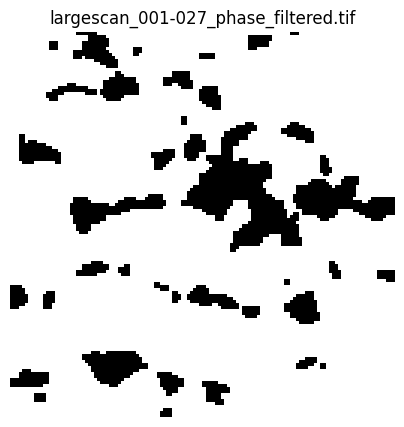

In [6]:
# Replace this with actual image shapes if saved separately
image_shapes = [(128, 128) for _ in range(len(df))]  # Example shape: 128x128 for all images

# Display a few images
display_images_from_dataframe(df, image_shapes, num_images=1)


In [8]:
# Define the encoder
class Sampling(layers.Layer):
    def call(self, inputs):
        """Reparameterization trick: sample from N(0, 1) scaled by the learned parameters."""
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(image_shape, latent_dim):
    encoder_inputs = layers.Input(shape=image_shape)
    x = layers.Conv2D(64, (3, 3), activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(128, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder




def build_decoder(latent_dim, original_shape):

    decoder_inputs = layers.Input(shape=(latent_dim,))
    
    # Dense layer to match the size before reshaping
    x = layers.Dense(16 * 16 * 256, activation="relu")(decoder_inputs)  # Match the final downsampled shape in encoder
    x = layers.Reshape((16, 16, 256))(x)  # Reshape to spatial dimensions
    
    # Upsampling using Conv2DTranspose layers
    x = layers.Conv2DTranspose(256, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation="relu", strides=2, padding="same")(x)
    
    # Final layer to output the image with the original shape
    decoder_outputs = layers.Conv2DTranspose(original_shape[-1], (3, 3), activation="sigmoid", padding="same")(x)
    
    # Define the decoder model
    decoder = models.Model(decoder_inputs, decoder_outputs, name="decoder")
    
    return decoder



# Define the VAE
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            ))
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + 0.1* kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

In [9]:
# Instantiate and compile the VAE
latent_dim = 128
image_shape = (128, 128, 1)
encoder = build_encoder(image_shape, latent_dim)
decoder = build_decoder(latent_dim, image_shape)
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

def preprocess_images(df, image_shapes):
    """
    Preprocess the flattened images back to their original shape and normalize.
    """
    images = [df.iloc[i].to_numpy().reshape(image_shapes[i]) for i in range(len(df))]
    images = np.expand_dims(images, axis=-1)  # Add channel dimension for grayscale
    images = images.astype("float32")  # Normalize pixel values to [0, 1]
    return images



images = preprocess_images(df, image_shapes)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=20, restore_best_weights=True)


history = vae.fit(images, images, epochs=1000, batch_size=32, callbacks=[early_stopping])

Epoch 1/1000


2025-01-27 15:39:11.287800: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 665ms/step - kl_loss: 2770160128.0000 - loss: 277554336.0000 - reconstruction_loss: 538328.9375
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 631ms/step - kl_loss: 2122.9106 - loss: 10183.0928 - reconstruction_loss: 9970.8018
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 629ms/step - kl_loss: 86.5117 - loss: 11056.8564 - reconstruction_loss: 11048.2051
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 658ms/step - kl_loss: 20.4145 - loss: 11025.7393 - reconstruction_loss: 11023.6973
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step - kl_loss: 7.3373 - loss: 10941.6113 - reconstruction_loss: 10940.8779
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 734ms/step - kl_loss: 3.5043 - loss: 10852.5557 - reconstruction_loss: 10852.2051
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 667ms/step - kl_loss: 2.0838 - loss: 10762.8320 - reconstruction_loss: 10762.6230
Epoch 8/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 697ms/step - kl_loss: 1.6376 - loss: 10673.9258 - reconstruction_loss: 10673.7627
Epoch 9/100

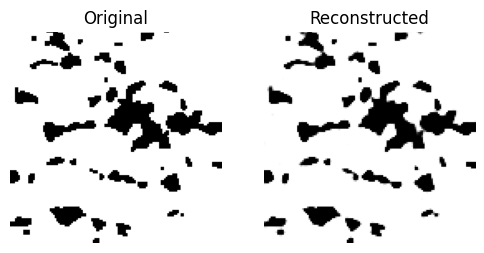

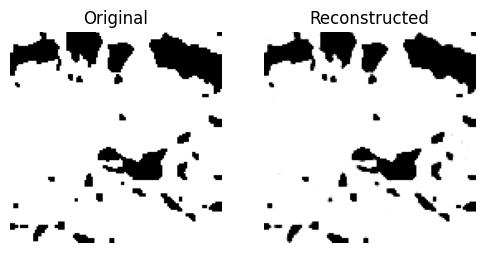

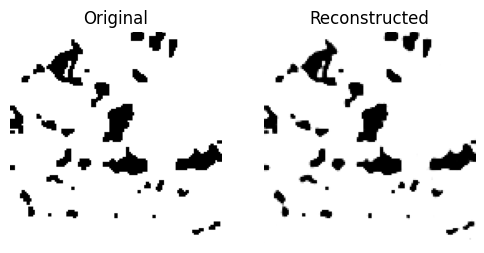

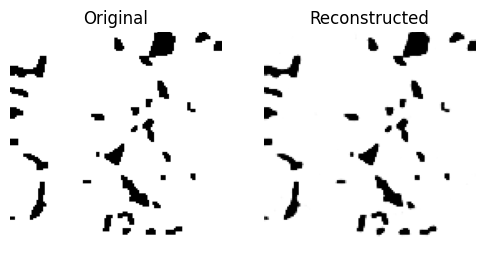

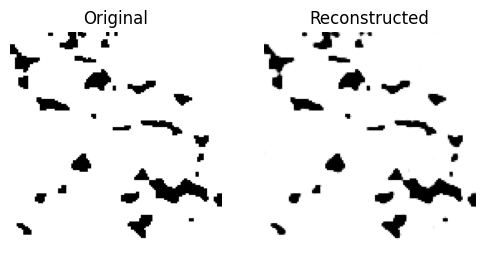

In [10]:
# Show original and reconstructed images
sample_images = images[:5]  # Select the first 5 images
reconstructed_images = vae.decoder(vae.encoder(sample_images)[2]).numpy()

for i in range(len(sample_images)):
    plt.figure(figsize=(6, 3))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(sample_images[i], cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_images[i], cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

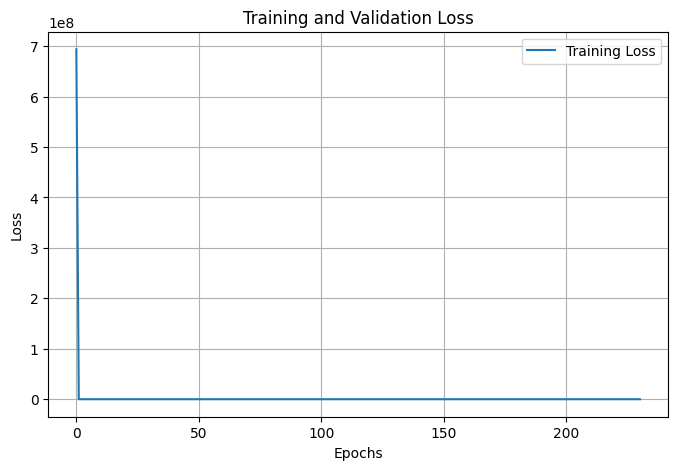

In [11]:
# Extract loss and validation loss from history
loss = history.history['loss']
#val_loss = history.history['val_loss']

# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


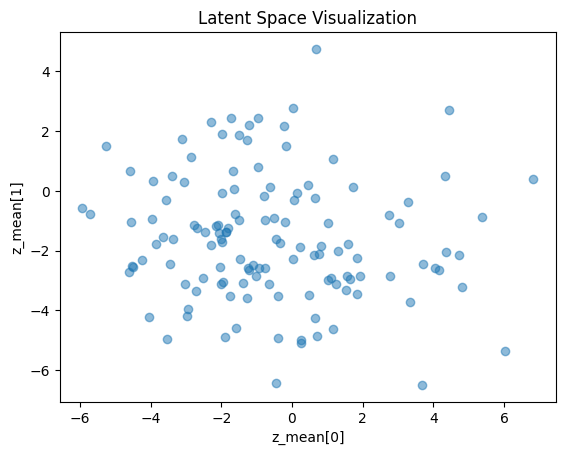

In [12]:
# Visualize the latent space
z_mean, z_log_var, _ = encoder.predict(images)
plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.5)
plt.title("Latent Space Visualization")
plt.xlabel("z_mean[0]")
plt.ylabel("z_mean[1]")
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


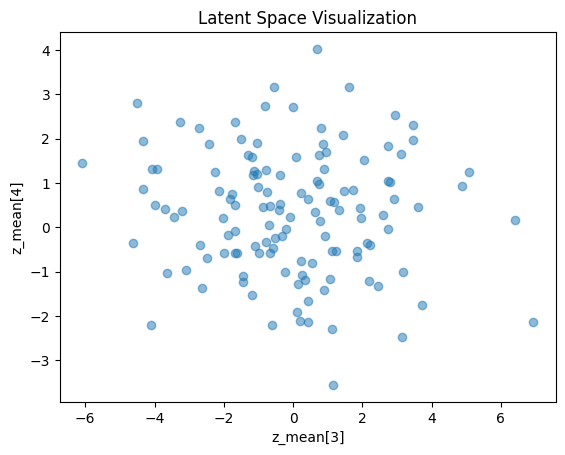

In [13]:
# Visualize the latent space
z_mean, z_log_var, _ = encoder.predict(images)
plt.scatter(z_mean[:, 62], z_mean[:, 63], alpha=0.5)
plt.title("Latent Space Visualization")
plt.xlabel("z_mean[3]")
plt.ylabel("z_mean[4]")
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


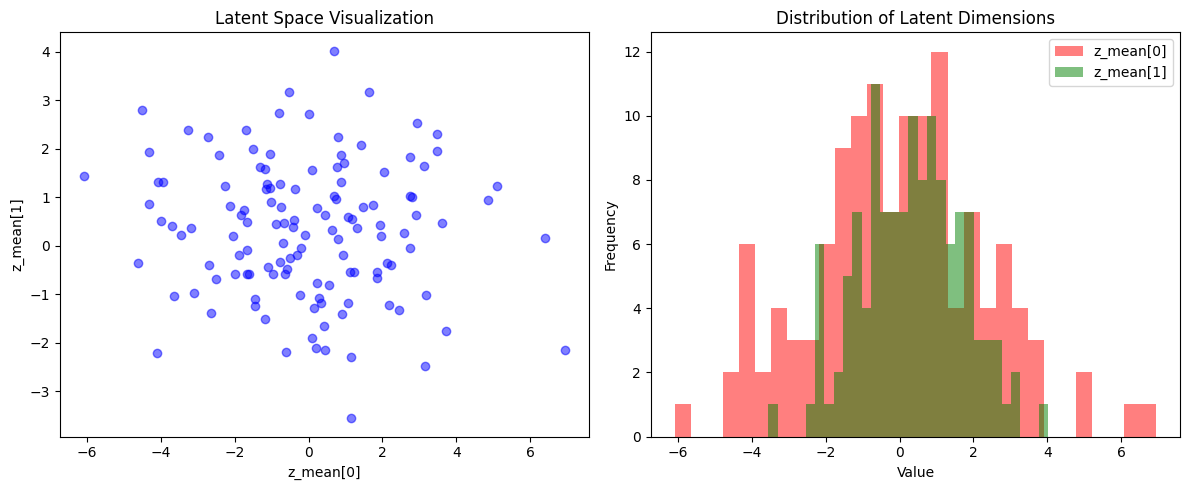

In [14]:
# Visualize the latent space
z_mean, z_log_var, _ = encoder.predict(images)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

plt.scatter(z_mean[:, 62], z_mean[:, 63], alpha=0.5, color='blue')

plt.title("Latent Space Visualization")

plt.xlabel("z_mean[0]")

plt.ylabel("z_mean[1]")



# Plot 2: Distribution of z_mean[0] and z_mean[1]

plt.subplot(1, 2, 2)

plt.hist(z_mean[:, 62], bins=30, alpha=0.5, label='z_mean[0]', color='red')

plt.hist(z_mean[:, 63], bins=30, alpha=0.5, label='z_mean[1]', color='green')

plt.title("Distribution of Latent Dimensions")

plt.xlabel("Value")

plt.ylabel("Frequency")

plt.legend()



plt.tight_layout()

plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


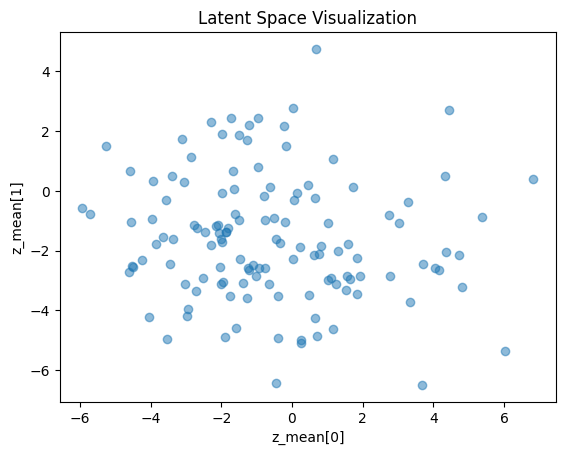

In [15]:
# Visualize the latent space
z_mean, z_log_var, _ = encoder.predict(images)
plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.5)
plt.title("Latent Space Visualization")
plt.xlabel("z_mean[0]")
plt.ylabel("z_mean[1]")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


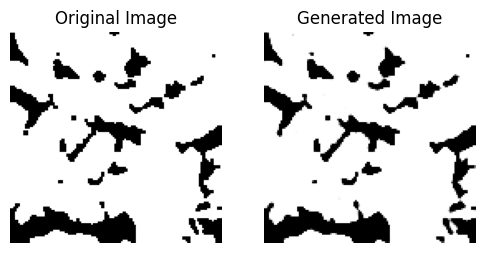

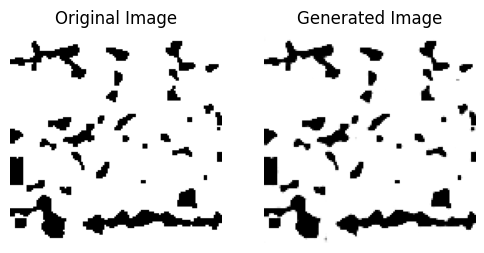

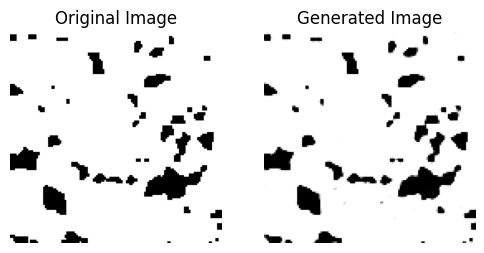

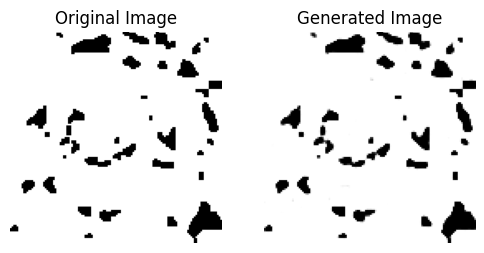

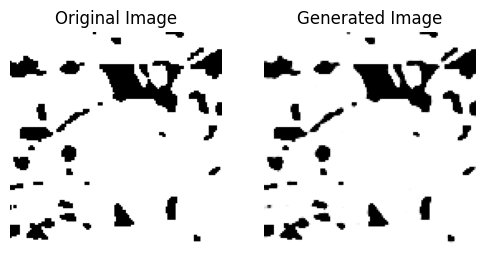

In [22]:
# Modified function to sample and return original and generated images
def sample_and_plot_original_generated(vae, images, num_samples=5):
    """
    Samples random images from the dataset, generates new images from the VAE,
    and plots the original and generated images side by side.
    
    Parameters:
        vae (VAE): The trained VAE model.plt.figure(figsize=(12, 5))
        images (np.ndarray): The training dataset (normalized images).
    """
    # Select random indices from the dataset
    random_indices = np.random.choice(len(images), num_samples, replace=False)
    original_images = images[random_indices]  # Original images

    # Get latent space mean and log variance for the selected images
    z_mean, z_log_var, _ = vae.encoder.predict(original_images)

    # Sample latent vectors using the reparameterization trick
    sampled_latent_vectors = []
    for i in range(num_samples):
        mean = z_mean[i]
        log_var = z_log_var[i]
        epsilon = 2
        sampled_latent_vector = mean + np.exp(0.5 * log_var) * epsilon
        sampled_latent_vectors.append(sampled_latent_vector)
    
    sampled_latent_vectors = np.array(sampled_latent_vectors)

    # Decode the sampled latent vectors into images
    generated_images = vae.decoder.predict(sampled_latent_vectors)

    # Plot original and generated images side by side
    for i in range(num_samples):
        plt.figure(figsize=(6, 3))
        
        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_images[i], cmap="gray")
        plt.title("Original Image")
        plt.axis("off")
        
        # Generated image
        plt.subplot(1, 2, 2)
        plt.imshow(generated_images[i], cmap="gray")
        plt.title("Generated Image")
        plt.axis("off")
        
        plt.show()

# Use the modified function to plot original and generated images
num_samples = 5  # Number of images to sample and generate
sample_and_plot_original_generated(vae, images, num_samples=num_samples)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


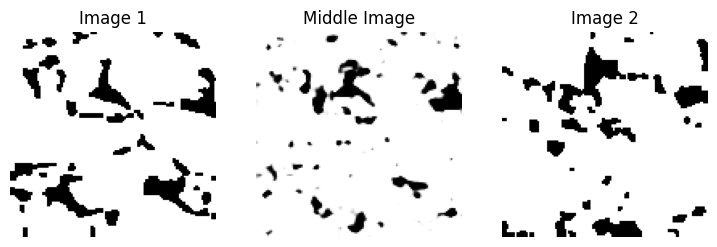

In [17]:
# Generate a middle image between two samples
def generate_middle_image(vae, images):
    """
    Generate a middle image by interpolating between two random images in the latent space.

    Parameters:
        vae (VAE): The trained VAE model.
        images (np.ndarray): The training dataset# Visualize the latent space
    """
    # Select two random images
    idx1, idx2 = np.random.choice(len(images), 2, replace=False)
    image1, image2 = images[idx1], images[idx2]

    # Encode the images to get latent representations
    z_mean1, _, _ = vae.encoder.predict(np.expand_dims(image1, axis=0))
    z_mean2, _, _ = vae.encoder.predict(np.expand_dims(image2, axis=0))

    # Interpolate between the two latent vectors
    z_middle = 0.5 * (z_mean1 + z_mean2)

    # Decode the interpolated latent vector to generate the middle image
    middle_image = vae.decoder.predict(z_middle)

    # Plot the original images and the middle image
    plt.figure(figsize=(9, 3))

    # Original image 1
    plt.subplot(1, 3, 1)
    plt.imshow(image1, cmap="gray")
    plt.title("Image 1")
    plt.axis("off")

    # Middle image
    plt.subplot(1, 3, 2)
    plt.imshow(middle_image[0], cmap="gray")
    plt.title("Middle Image")
    plt.axis("off")

    # Original image 2
    plt.subplot(1, 3, 3)
    plt.imshow(image2, cmap="gray")
    plt.title("Image 2")
    plt.axis("off")

    plt.show()

# Generate and display the middle image
generate_middle_image(vae, images)
